In [238]:
from os import path
import pickle

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from pyia import GaiaData
import emcee

from model import OrbitFitModel

In [239]:
galcen_frame = coord.Galactocentric(galcen_distance=8.1*u.kpc, 
                                    z_sun=0*u.pc)

### Read data:

In [240]:
g = GaiaData('../data/Sheffield2014-Gaia-master.fits')
l0 = 160*u.deg

# ---------------------------------

# g = GaiaData('../data/Li2017-Gaia-master.fits')
# l0 = 220*u.deg

### Set up coordinates we'll use to fit:

Here we use the RVs derived by Ally or Ting because they are at least consistent for all sources in each batch, and seem to agree with Maria's to ~6 km/s or so. To be conservative, we set the RV error to 8 km/s and the distance error to 15%:

In [245]:
c = g.get_skycoord(distance=g.apw_distance*u.kpc,
                   radial_velocity=g.rv*u.km/u.s)

ERROR! Session/line number was not unique in database. History logging moved to new session 8831


In [242]:
rv_err = 8. # km/s
dist_frac_err = 0.15 # 15%

In [243]:
c_ref = gc.reflex_correct(c)
gal = c.galactic
gal_ref = gc.reflex_correct(gal)
galcen = c.transform_to(galcen_frame)

In [244]:
cov = g.get_cov()[:, 3:5, 3:5]

Prepare the data and error dictionaries we use in the likelihood to avoid dealing with unit transformations:

In [219]:
data = dict()
for k in component_names(gal):
    data[k] = getattr(gal, k).to_value(_units[k])

In [199]:
pm_err = np.array([np.sqrt(np.max(np.linalg.eigvals(cov[i]))) 
                   for i in range(cov.shape[0])]) # convervative approximation!

errs = dict()
errs['b'] = 0. # assume no error on b
errs['distance'] = dist_frac_err * data['distance'] # 10% distance errors
errs['pm_l_cosb'] = pm_err
errs['pm_b'] = pm_err
errs['radial_velocity'] = rv_err

In [ ]:
pos_sigma = 1 * u.kpc
vel_sigma = 20 * u.km/u.s

bg_pos_sigma = 50 * u.kpc
bg_vel_sigma = 150 * u.km/u.s

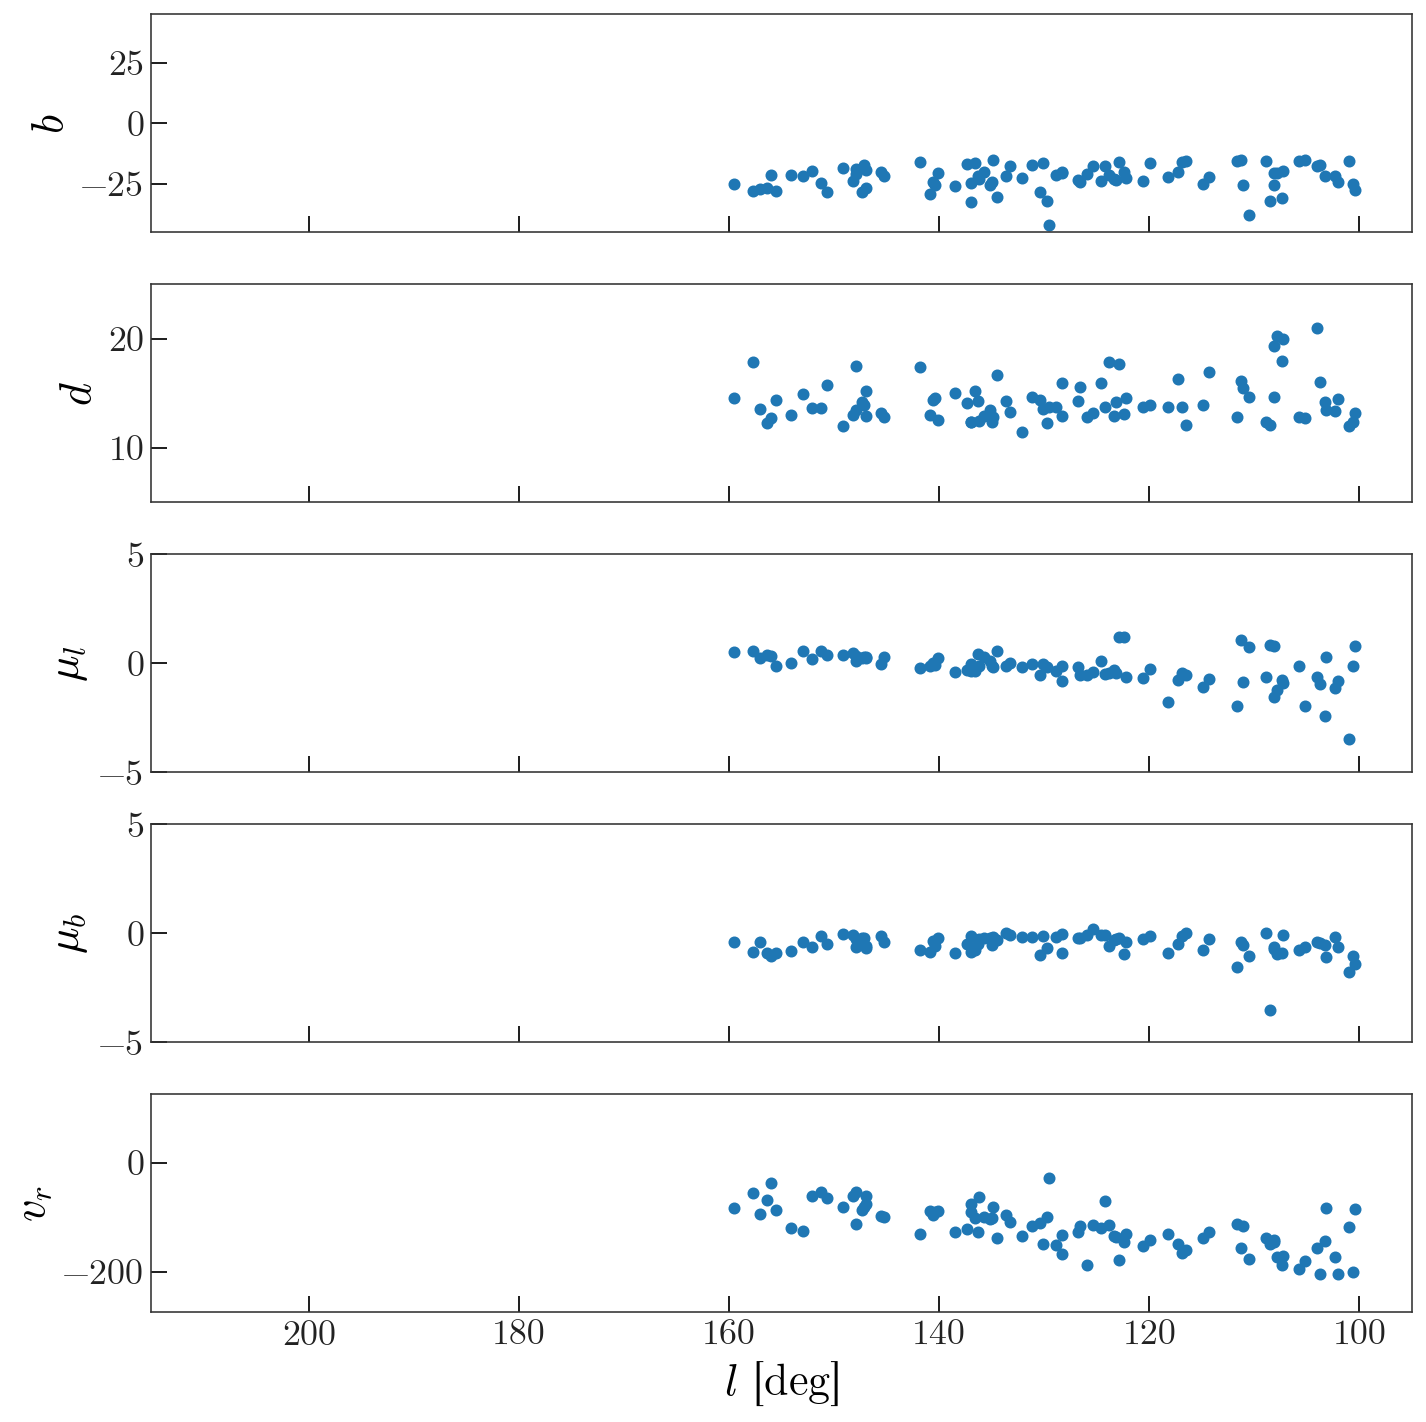

In [166]:
fig, axes = plt.subplots(5, 1, figsize=(10, 10),
                         sharex=True)

for i, name in enumerate(['b', 'distance', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    axes[i].scatter(gal.l.degree, 
                    getattr(gal, name).value)

axes[0].set_ylim(-45, 45)
axes[1].set_ylim(5, 25)
axes[2].set_ylim(-5, 5)
axes[3].set_ylim(-5, 5)
axes[4].set_ylim(-275, 125)

axes[0].set_xlim(215, 95)

axes[0].set_ylabel(r'$b$')
axes[1].set_ylabel(r'$d$')
axes[2].set_ylabel(r'$\mu_l$')
axes[3].set_ylabel(r'$\mu_b$')
axes[4].set_ylabel('$v_r$')
axes[-1].set_xlabel('$l$ [deg]')

fig.tight_layout()

In [233]:
ham.potential.parameters

OrderedDict([('m', <Quantity 5.e+11 solMass>), ('c', <Quantity 15. kpc>)])

In [170]:
l0 = 160*u.deg
p0 = [1., -25., 13., 0.2, -0.2, -40., np.log(15)]

# l0 = 220*u.deg
# p0 = [1., 25., 13., 0.2, -0.2, -40., np.log(15)]

# ham = gp.Hamiltonian(gp.MilkyWayPotential())
ham = gp.Hamiltonian(gp.HernquistPotential(m=5e11, c=15, units=galactic))
assert np.all(np.isfinite(ln_posterior(p0, l0, data, errs, ham, galcen_frame)))

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in log


### Profile the likelihood function:

In [171]:
# %load_ext line_profiler

In [172]:
# %lprun -f get_orbit_gal ln_posterior(p0, l0, data, errs, ham, galcen_frame)

### Check orbit computed from initial parameters:

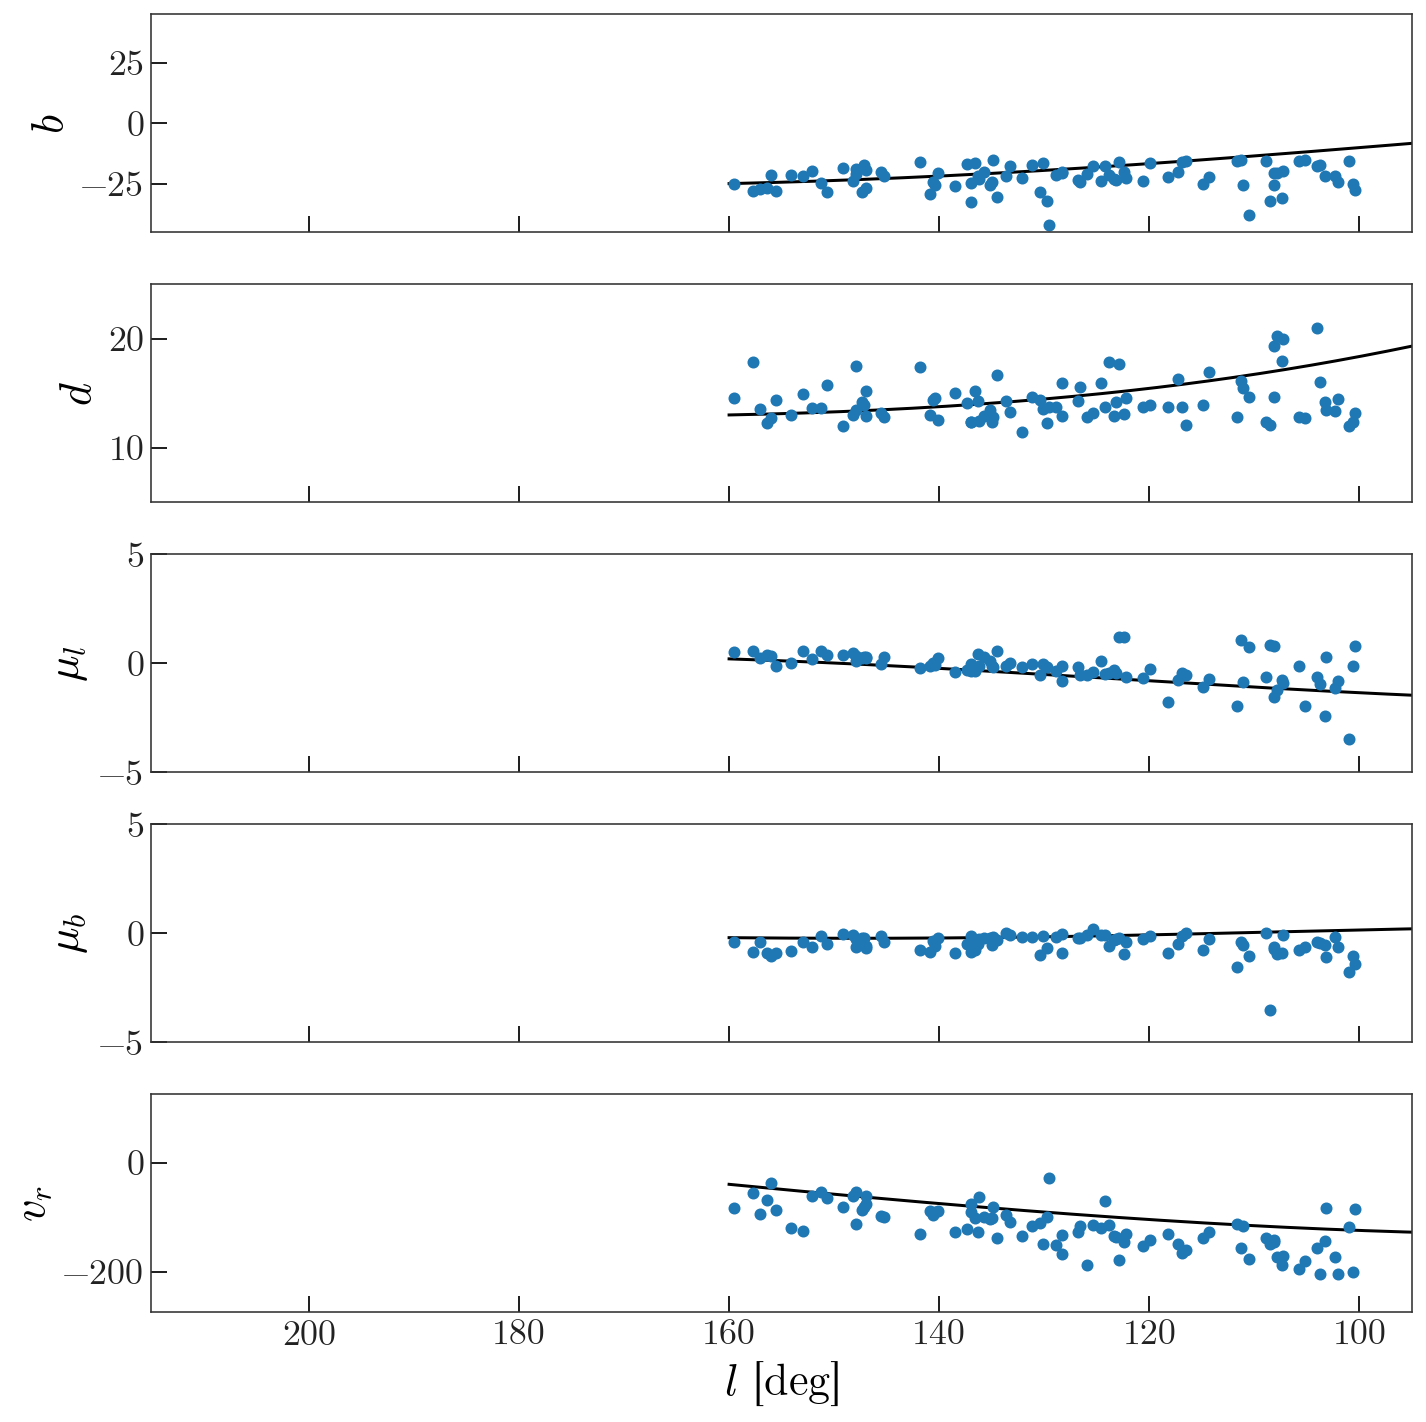

In [173]:
orbit = get_orbit_gal(p0[1:], l0, ham, galcen_frame)

fig, axes = plt.subplots(5, 1, figsize=(10, 10),
                         sharex=True)

for i, name in enumerate(['b', 'distance', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    axes[i].scatter(gal.l.degree, 
                    getattr(gal, name).value)
    axes[i].plot(orbit.l.degree,
                 getattr(orbit, name).value, 
                 marker='', color='k', zorder=-10)

axes[0].set_ylim(-45, 45)
axes[1].set_ylim(5, 25)
axes[2].set_ylim(-5, 5)
axes[3].set_ylim(-5, 5)
axes[4].set_ylim(-275, 125)

axes[0].set_xlim(215, 95)

axes[0].set_ylabel(r'$b$')
axes[1].set_ylabel(r'$d$')
axes[2].set_ylabel(r'$\mu_l$')
axes[3].set_ylabel(r'$\mu_b$')
axes[4].set_ylabel('$v_r$')
axes[-1].set_xlabel('$l$ [deg]')

fig.tight_layout()

### First optimize to get best-fit orbital parameters

In [183]:
args = (l0, data, errs, ham, galcen_frame)

In [126]:
res = minimize(lambda *args, **kwargs: -ln_posterior(*args, **kwargs),
               x0=p0, args=args, 
               method='powell')

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:89: RuntimeWarning: divide by zero encountered in log
/Users/adrian/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


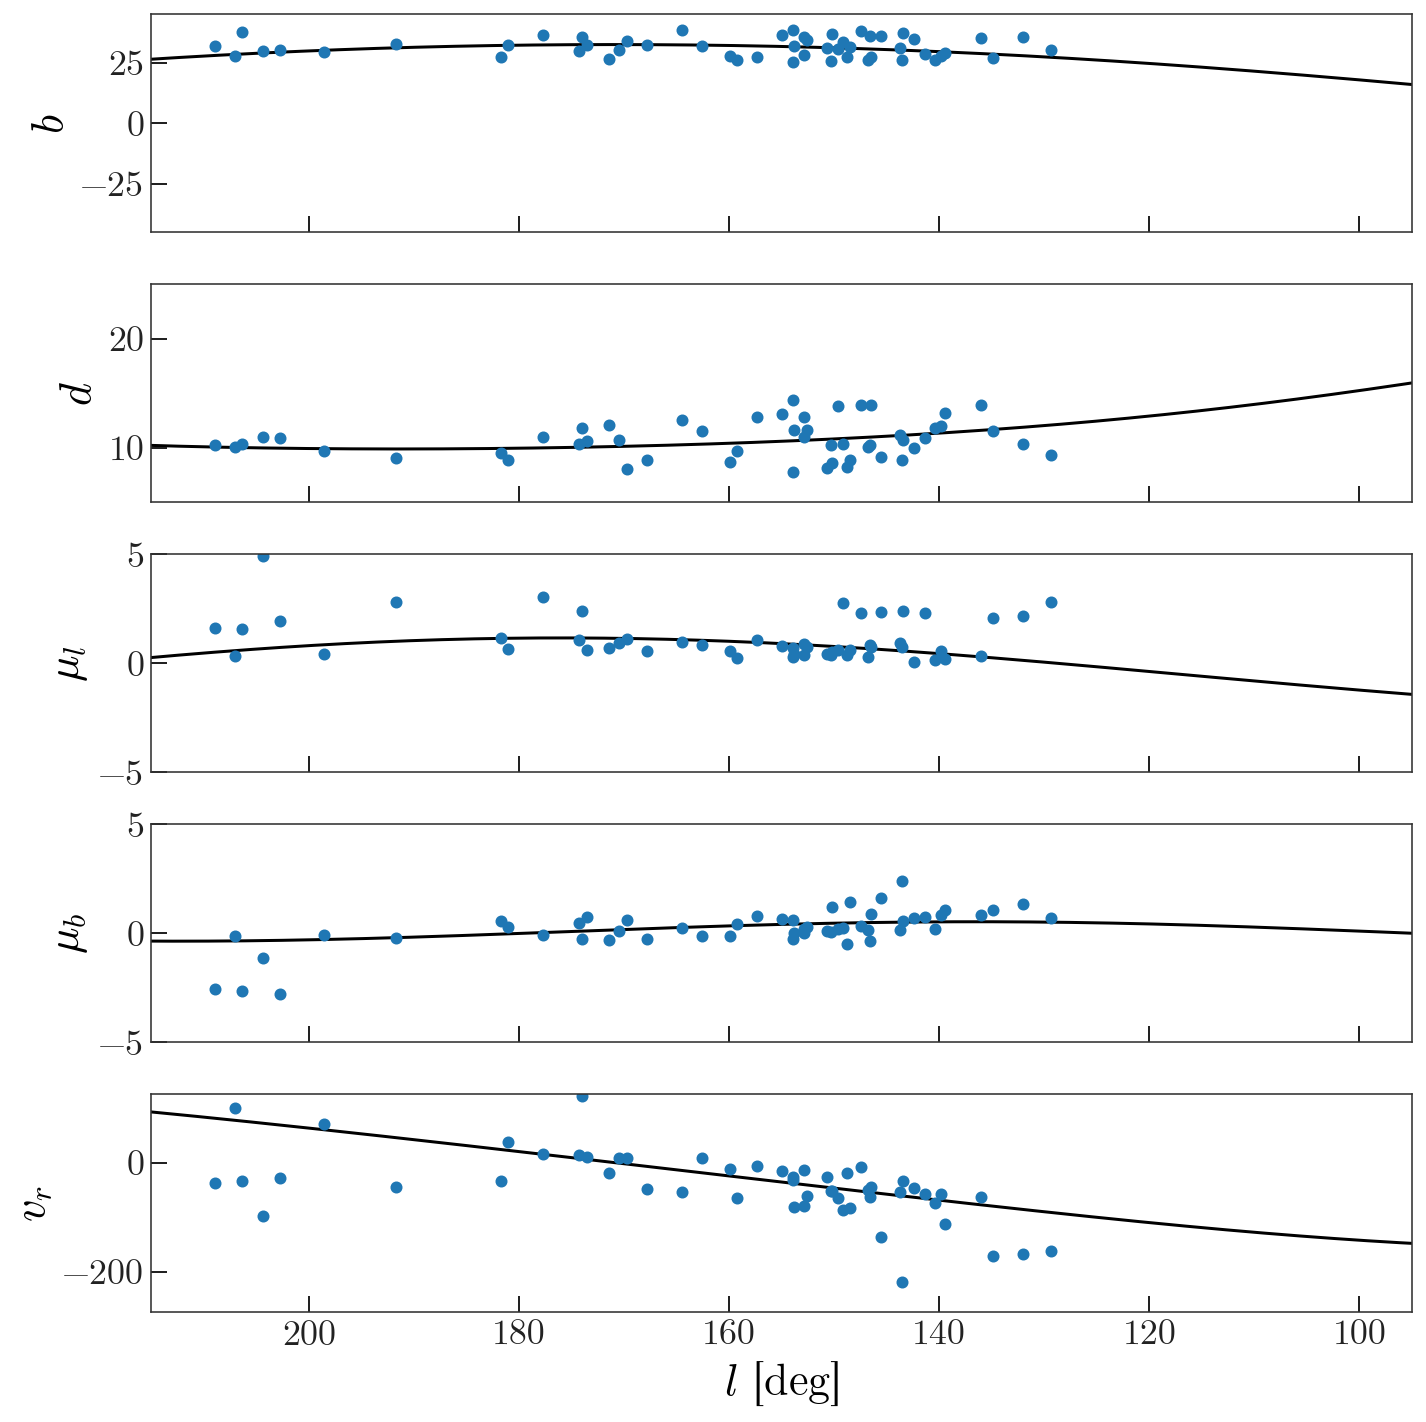

In [127]:
orbit = get_orbit_gal(res.x[1:], l0, ham, galcen_frame)

fig, axes = plt.subplots(5, 1, figsize=(10, 10),
                         sharex=True)

for i, name in enumerate(['b', 'distance', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    axes[i].scatter(gal.l.degree, 
                    getattr(gal, name).value)
    
    x = orbit.l.degree.copy()
    y = getattr(orbit, name).value.copy()
    pos = np.where(np.abs(np.diff(x)) >= 10)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    axes[i].plot(x, y, 
                 marker='', color='k', zorder=-10)

axes[0].set_ylim(-45, 45)
axes[1].set_ylim(5, 25)
axes[2].set_ylim(-5, 5)
axes[3].set_ylim(-5, 5)
axes[4].set_ylim(-275, 125)

axes[0].set_xlim(215, 95)

axes[0].set_ylabel(r'$b$')
axes[1].set_ylabel(r'$d$')
axes[2].set_ylabel(r'$\mu_l$')
axes[3].set_ylabel(r'$\mu_b$')
axes[4].set_ylabel('$v_r$')
axes[-1].set_xlabel('$l$ [deg]')

fig.tight_layout()

### Run `emcee` from the best-fit parameters:

In [174]:
nwalkers = len(p0) * 8
print('nwalkers: {0}'.format(nwalkers))

sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=len(p0), 
                                log_prob_fn=ln_posterior, args=args)

nwalkers: 56


In [175]:
p0s = emcee.utils.sample_ball(res.x, [1e-4] * len(p0), size=nwalkers)

for pp in p0s:
    assert np.all(np.isfinite(ln_posterior(pp, l0, data, errs, ham, galcen_frame)))

In [176]:
filename = '../cache/triand-sampler.pickle'
# filename = '../cache/a13-sampler.pickle'
if not path.exists(filename):
    pos, *_ = sampler.run_mcmc(p0s, nsteps=1024, 
                               progress=True)
    sampler.log_prob_fn = None
    with open(filename, 'wb') as f:
        pickle.dump(sampler, f)
        
else:
    with open(filename, 'rb') as f:
        sampler = pickle.load(f)

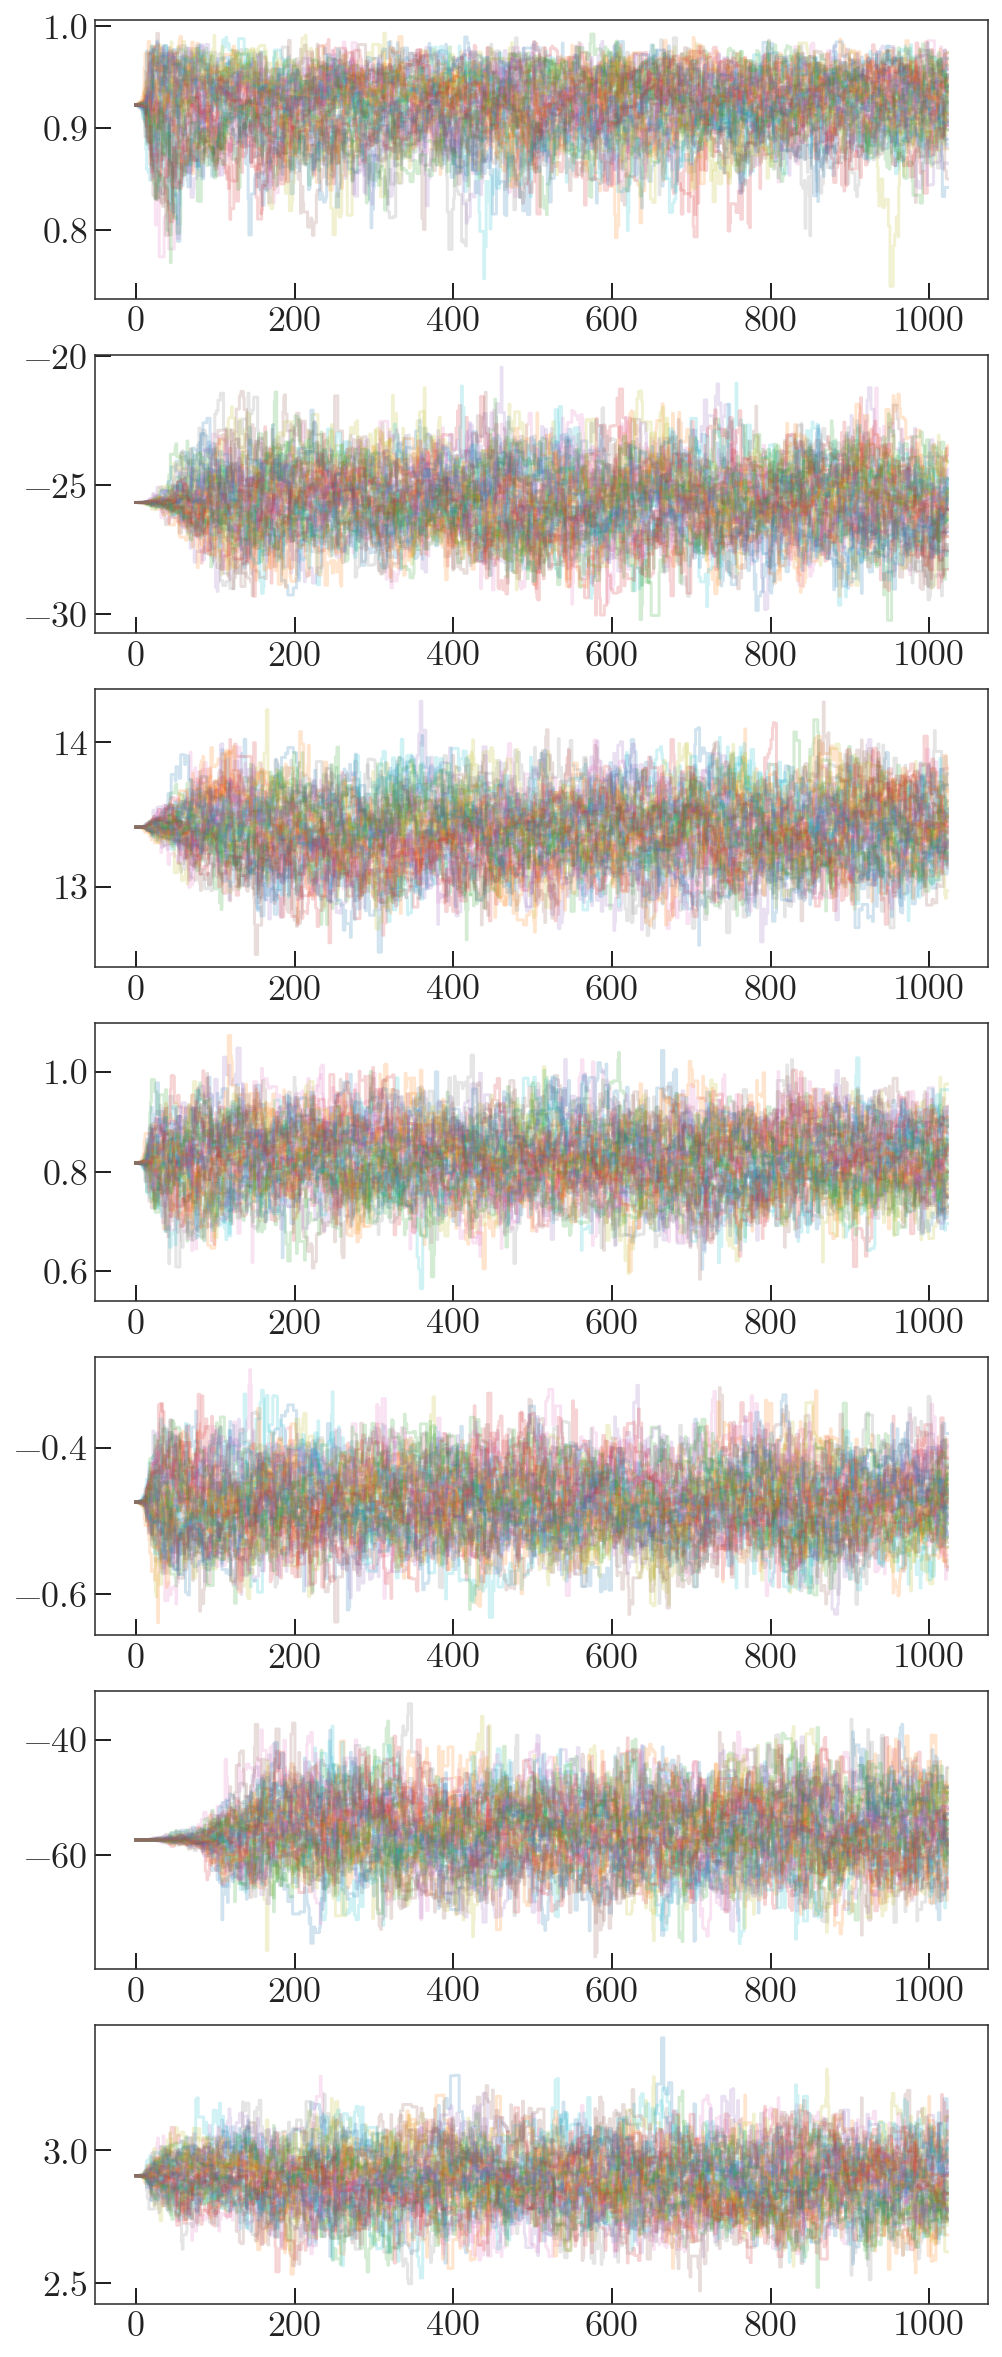

In [178]:
fig, axes = plt.subplots(sampler.chain.shape[-1], 1, 
                         figsize=(8, 3*sampler.chain.shape[-1]))
for k, ax in enumerate(axes):
    for walker in sampler.chain[..., k]:
        ax.plot(walker, marker='', drawstyle='steps-mid',
                alpha=0.2)

In [182]:
flatchain = np.vstack(sampler.chain[:, 512:])
flatlnprob = np.ravel(sampler.lnprobability[512:].T) # TODO: remove the .T when emcee is fixed

Note: this is an approximation to the marginalization I should be doing...

In [184]:
f, *other_p = flatchain[flatlnprob.argmax()]
ll1 = ln_likelihood_fg(other_p, *args) + np.log(f)
ll2 = ln_likelihood_bg(other_p, *args) + np.log(1 - f)
star_prob = np.exp(ll1 - np.logaddexp(ll1, ll2))

In [186]:
star_prob > 0.8

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False])

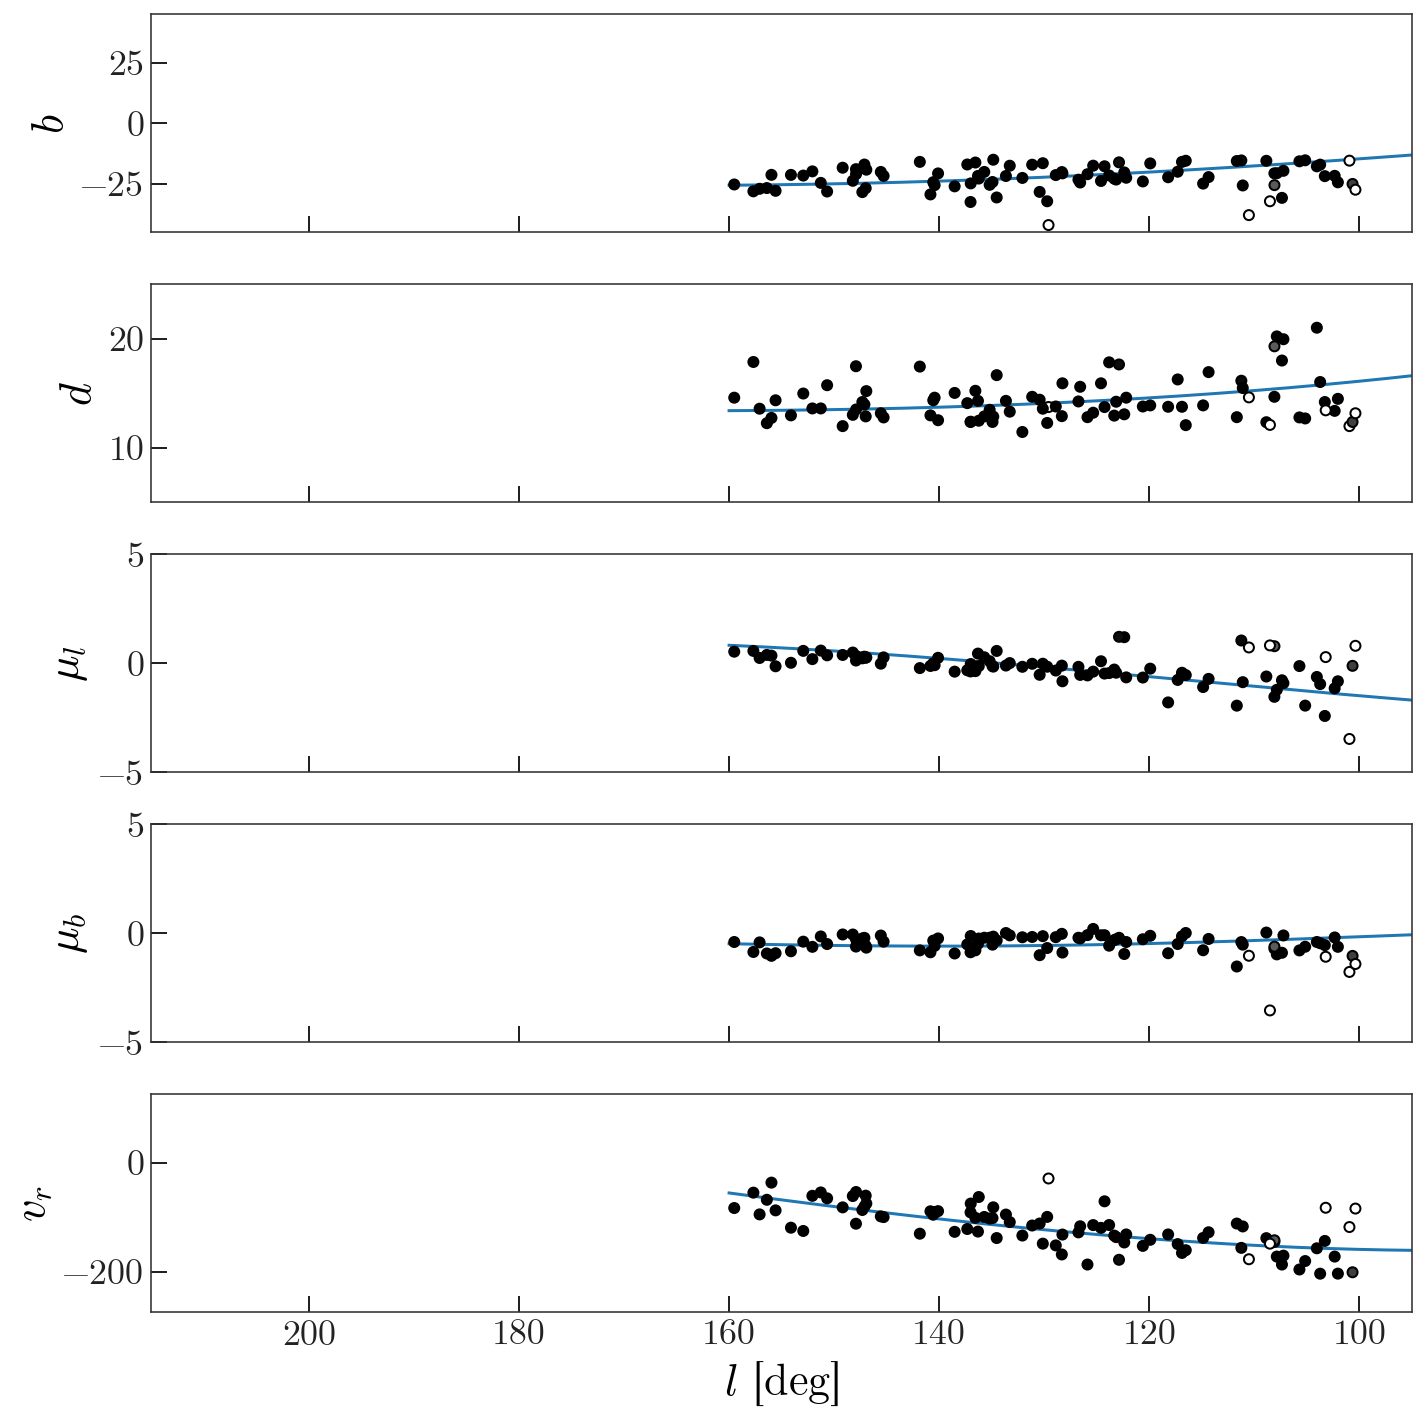

In [188]:
mean_p = np.mean(np.vstack(sampler.chain[:, 512:]), axis=0)

orbit = get_orbit_gal(mean_p[1:], l0, ham, galcen_frame)

fig, axes = plt.subplots(5, 1, figsize=(10, 10),
                         sharex=True)

for i, name in enumerate(['b', 'distance', 'pm_l_cosb', 'pm_b', 'radial_velocity']):
    axes[i].scatter(gal.l.degree, 
                    getattr(gal, name).value,
                    c=star_prob, cmap='Greys', 
                    vmin=0, vmax=1, linewidth=1, edgecolor='k')
    
    x = orbit.l.degree.copy()
    y = getattr(orbit, name).value.copy()
    pos = np.where(np.abs(np.diff(x)) >= 10)[0]+1
    x = np.insert(x, pos, np.nan)
    y = np.insert(y, pos, np.nan)
    axes[i].plot(x, y, 
                 marker='', color='tab:blue', zorder=-10)

axes[0].set_ylim(-45, 45)
axes[1].set_ylim(5, 25)
axes[2].set_ylim(-5, 5)
axes[3].set_ylim(-5, 5)
axes[4].set_ylim(-275, 125)

axes[0].set_xlim(215, 95)

axes[0].set_ylabel(r'$b$')
axes[1].set_ylabel(r'$d$')
axes[2].set_ylabel(r'$\mu_l$')
axes[3].set_ylabel(r'$\mu_b$')
axes[4].set_ylabel('$v_r$')
axes[-1].set_xlabel('$l$ [deg]')

fig.tight_layout()
# fig.savefig('../plots/orbitfit.png', dpi=250)

In [189]:
dens = []
vcirc = []

flatchain = np.vstack(sampler.chain[:, 512:])
for k in np.random.choice(flatchain.shape[0], size=256, replace=False):
    p = flatchain[k]
    pot = gp.HernquistPotential(m=5e11, c=np.exp(p[-1]), 
                                units=galactic)
    
    q = [20., 0, 0] * u.kpc
    dens.append(pot.density(q).to(u.Msun / u.pc**3))
    vcirc.append(pot.circular_velocity(q).to(u.km / u.s))

dens = u.Quantity(dens)
vcirc = u.Quantity(vcirc)

In [135]:
np.mean(dens), np.std(dens)

(<Quantity 0.00118227 solMass / pc3>, <Quantity 0.00016432 solMass / pc3>)

In [136]:
np.mean(vcirc), np.std(vcirc)

(<Quantity 158.09699805 km / s>, <Quantity 19.98950183 km / s>)

In [190]:
np.mean(dens), np.std(dens)

(<Quantity 0.00130938 solMass / pc3>, <Quantity 5.66402189e-05 solMass / pc3>)

In [191]:
np.mean(vcirc), np.std(vcirc)

(<Quantity 173.81606761 km / s>, <Quantity 8.608824 km / s>)